In [1]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
  
if IN_COLAB:
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    drive_root = mount + "/My Drive/ML_for_fun/Stock prediction/Data"
    
    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok = True)
    
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data  exists.

Colab: Changing directory to  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data
/content/gdrive/My Drive/ML_for_fun/Stock prediction/Data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [111]:
from sklearn.metrics import mean_absolute_error

In [11]:
aapl=pd.read_csv('./AAPL.csv')
def prepare_dat(df):
  df2=df.copy()
  df2.set_index('Date',inplace=True)
  df2.index=pd.DatetimeIndex(df2.index).to_period('D')
  df2.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)
  return df2
aapl2=prepare_dat(aapl)
y=aapl2['Adj Close'].pct_change()
y.dropna(inplace=True)


In [14]:
ytrain,ytest=y[:3500],y[3500:]

In [155]:
y_cl_test=(ytest.values>0).astype(int)

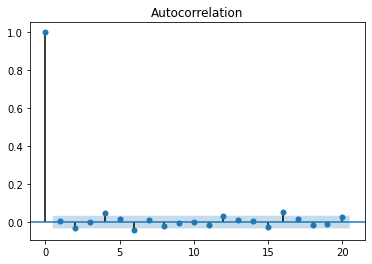

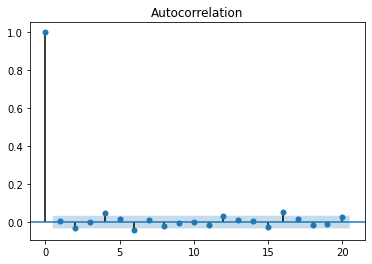

In [15]:
plot_acf(ytrain,lags=20)

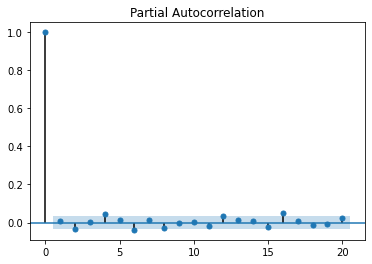

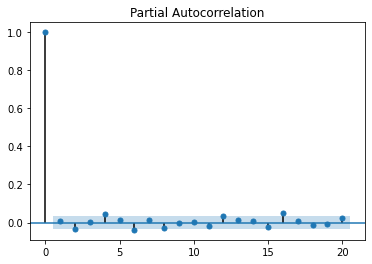

In [16]:
plot_pacf(ytrain,lags=20)

Based on ACF and PACF we suspect two potential models: ARMA(4,4) and ARMA(6,6). We will choose from these two models based on the value of Akaike Information Criterion

In [ ]:
ytest.shape

(637,)

In [17]:
model=SARIMAX(ytrain,order=(4,0,4))
model_fit=model.fit()
model_fit.aic

-17251.102768309876

In [18]:
model2=SARIMAX(ytrain,order=(6,0,6))
model_fit2=model2.fit()
model_fit2.aic

-17245.365756030722

For reference, let's also train the white noise model, i.e when p,d,q are 0, and see its AIC

In [19]:
model3=SARIMAX(ytrain,order=(0,0,0))
model_fit3=model3.fit()
model_fit3.aic

-17249.929653997497

AIC is smallest when p & q are 4, so we stick to this model

Next we perform the forecasting. We manually extract model coefficients and perform forecasting applying the direct definition of the ARMA(4,4) model

Wxtracting the parameters:

In [40]:
pars=model_fit.params

Defining the array needed to make predictions:

In [88]:
array_for_pred=np.array(ytrain[-4:])
array_for_pred=np.append(array_for_pred, ytest[:-1])

Defining white noise, let it for now be standard normal rv's.

In [106]:
random_norm=np.random.normal(0,1,size=array_for_pred.shape[0])

Now we apply the direct definition of ARMA(4,4) and build single-step forecasts from it

In [107]:
predictions_norm=np.empty(shape=ytest.shape[0])
for i in range(0, ytest.shape[0]):
  predictions_norm[i]=pars[0]*array_for_pred[i]+pars[1]*array_for_pred[i+1]+pars[2]*array_for_pred[i+2]+pars[3]*array_for_pred[i+3]+pars[4]*random_norm[i]+pars[5]*random_norm[i+1]+pars[6]*random_norm[i+2]+pars[7]*random_norm[i+3]

Now let's plot the results

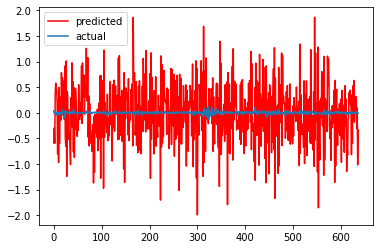

In [108]:
plt.plot(predictions_norm,color='red',label='predicted')
plt.plot(ytest.values,label='actual')
plt.legend()

Wow... Looks like we got too much. The problem seems to be coming from white noise: it dominates the AR terms and this all results in too much variability in scale

Solution? Let's try another white noise, with smaller standard deviation!


In [139]:
ytrain.std()

0.020541104115133456

In [140]:
random_norm2=np.random.normal(0,0.02,size=array_for_pred.shape[0])
predictions_norm2=np.empty(shape=ytest.shape[0])
for i in range(0, ytest.shape[0]):
  predictions_norm2[i]=pars[0]*array_for_pred[i]+pars[1]*array_for_pred[i+1]+pars[2]*array_for_pred[i+2]+pars[3]*array_for_pred[i+3]+pars[4]*random_norm2[i]+pars[5]*random_norm2[i+1]+pars[6]*random_norm2[i+2]+pars[7]*random_norm2[i+3]

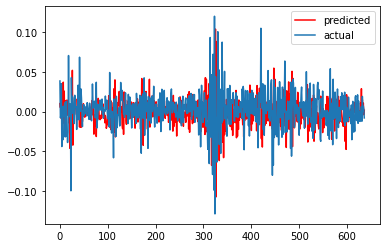

In [141]:
plt.plot(predictions_norm2,color='red',label='predicted')
plt.plot(ytest.values,label='actual')
plt.legend()

Now that is much better! Although we seem to underestimate some shocks...

In [142]:
mean_absolute_error(ytest,predictions_norm2)

0.0199772711809047

The MAE is higher though than it was for ML models...

Computing and plotting prices from the returns...

In [143]:
start_test=aapl2.loc['2018-11-28'].values
predicted_price=np.empty(ytest.shape[0])
predicted_price[0]=start_test
for i in range(1, predicted_price.shape[0]):
  predicted_price[i]=predicted_price[i-1]*(1+predictions_norm2[i])

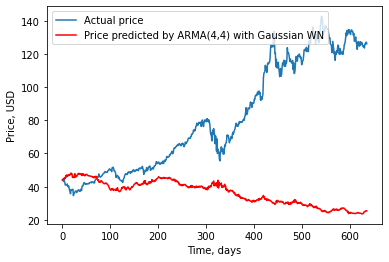

In [144]:
actual_price=aapl2.loc['2018-11-28':].values
plt.plot(actual_price)
plt.plot(predicted_price,color='red')
plt.xlabel('Time, days')
plt.ylabel('Price, USD')
plt.legend(['Actual price','Price predicted by ARMA(4,4) with Gaussian WN'])

Well, the computed price doesn't match the actual price at all as it is unable to capture even the general upward trend.

Finally, let's try classification 

In [161]:
pred_cl=(predictions_norm2>0).astype(int)
from sklearn.metrics import accuracy_score
print('Accuracy score Time Series:' ,accuracy_score(y_cl_test,pred_cl))

Accuracy score Time Series: 0.5274725274725275


Even in classification the time series model does not outperform the Random Forest and RNN...

This concludes our mini-research on comparing forecasts from classical ML, neural networks and time series modelling. For time series, I would also try other distribution with fatter tails for white noise (for ex., Student's t), but apparently, Python doesn't have enough functionality to operate on such intricate statistical grounds, for example, it doesn't offer the method for estimating the degrees of freedom parameter which is crucial when working with t-distribution. 